[Datasets](https://www.kaggle.com/paultimothymooney/breast-histopathology-images/)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
Root = "/content/drive/MyDrive/BreastCancer/TrainingDataSet"
os.chdir(Root)

In [ ]:
#Import the necessary libraries first

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import cv2

In [ ]:
data = '/content/drive/MyDrive/BreastCancer/TrainingDataSet'
No_breast_cancer = '/content/drive/MyDrive/BreastCancer/TrainingDataSet/0'
Yes_breast_cancer = '/content/drive/MyDrive/BreastCancer/TrainingDataSet/1'

In [ ]:
dirlist=[No_breast_cancer, Yes_breast_cancer]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  3395    labels:  3395


In [ ]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(3395,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/BreastCancer/TrainingDa...,No
1,/content/drive/MyDrive/BreastCancer/TrainingDa...,No
2,/content/drive/MyDrive/BreastCancer/TrainingDa...,No
3,/content/drive/MyDrive/BreastCancer/TrainingDa...,No
4,/content/drive/MyDrive/BreastCancer/TrainingDa...,No


In [ ]:
print(df['labels'].value_counts())

No     2086
Yes    1309
Name: labels, dtype: int64


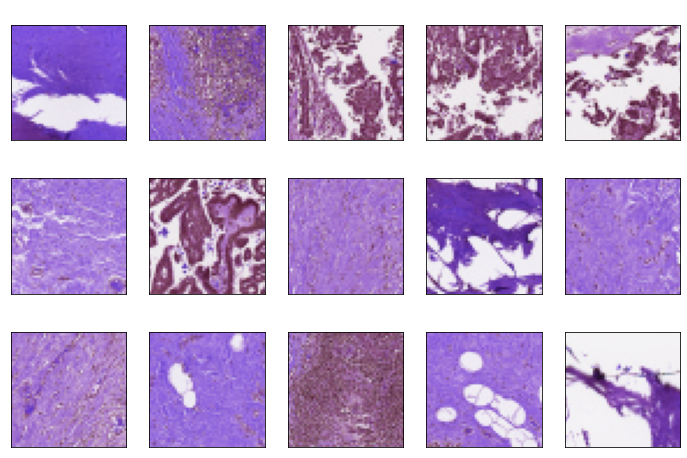

In [ ]:
#visualize breast cancer images

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (2902, 2)
test set shape: (170, 2)
validation set shape: (323, 2)


In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 2902 validated image filenames belonging to 2 classes.
Found 323 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.


In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

**Transfer Learning**

In [ ]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
91/91 [==============================] - 1626s 18s/step - loss: 0.5878 - accuracy: 0.6961 - val_loss: 0.4782 - val_accuracy: 0.8080
Epoch 2/100
91/91 [==============================] - 44s 488ms/step - loss: 0.4558 - accuracy: 0.8139 - val_loss: 0.3754 - val_accuracy: 0.8669
Epoch 3/100
91/91 [==============================] - 43s 476ms/step - loss: 0.3808 - accuracy: 0.8653 - val_loss: 0.3163 - val_accuracy: 0.8885
Epoch 4/100
91/91 [==============================] - 43s 474ms/step - loss: 0.3438 - accuracy: 0.8766 - val_loss: 0.3059 - val_accuracy: 0.8916
Epoch 5/100
91/91 [==============================] - 45s 489ms/step - loss: 0.3132 - accuracy: 0.8846 - val_loss: 0.2793 - val_accuracy: 0.8978
Epoch 6/100
91/91 [==============================] - 43s 477ms/step - loss: 0.2954 - accuracy: 0.8949 - val_loss: 0.2636 - val_accuracy: 0.8916
Epoch 7/100
91/91 [==============================] - 43s 475ms/step - loss: 0.2842 - accuracy: 0.8980 - val_loss: 0.2516 - val_accuracy:

In [ ]:
model.save("model.h5")

**Evaluating the model**

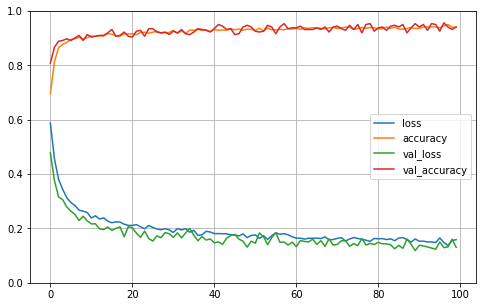

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
from PIL import Image
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

# import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/BreastCancer/TrainingDataSet/1/10302_idx5_x1851_y1201_class1.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred >= 0.5:
  print("Yes")
else:
  print("No")

Yes


In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}